# Census Population Data (2020) + NYC Tree Census Data (2015)

### Tress per square mile (by Census Tract) 

### STATEN ISLAND

In [71]:
# load libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import pysal as ps
import libpysal
import esda
from pysal.lib import weights
from splot.esda import plot_moran
from splot.esda import plot_local_autocorrelation

In [72]:
# read in data
trees_cts = gpd.read_file("data/trees_cts.geojson")

In [73]:
trees_cts.head()

,GEOID,population,census tract,county,tree_count,trees_per_capita,area_per_sqmile,trees_per_sqmile,geometry
0,36005012701,1664.0,127.01,Bronx,201.0,0.120793,0.041620,4829.377806,"POLYGON ((-7129744.449 4787818.802, -7129654.2..."
1,36005037300,4365.0,373,Bronx,211.0,0.048339,0.066843,3156.671549,"POLYGON ((-7129604.833 4789904.712, -7129520.2..."
2,36005011900,4276.0,119,Bronx,247.0,0.057764,0.063114,3913.558552,"POLYGON ((-7129505.357 4787665.982, -7129427.7..."
3,36005039100,5255.0,391,Bronx,364.0,0.069267,0.079709,4566.636743,"POLYGON ((-7129221.590 4790683.165, -7129136.5..."
4,36005007900,4957.0,79,Bronx,297.0,0.059915,0.076384,3888.228621,"POLYGON ((-7131068.335 4786855.710, -7130944.4..."


In [74]:
# check county names
print(trees_cts['county'].drop_duplicates().to_list())

['Bronx', 'Kings', 'Queens', 'Richmond', 'New York']


In [105]:
# look at only Staten Island
SI_trees_sqmile = trees_cts.query("county == 'Richmond'")

[Text(0.5, 1.0, 'Staten Island')]

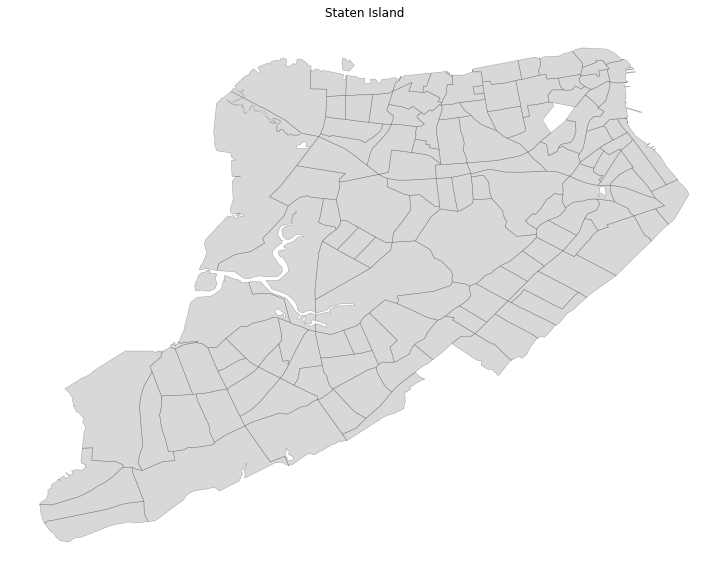

In [106]:
# check plot

# create a figure with one subplot
fig, ax = plt.subplots(figsize=(20,10))

# plot census tracts
SI_trees_sqmile.plot(ax = ax, alpha = 0.3, edgecolor = 'black', linewidth = 0.5, color = 'gray')

ax.axis('off')
ax.set(title = 'Staten Island')

In [107]:
# first - drop cells containing Null values (cells containing zero points) - or code will not work
SI_trees_sqmile = SI_trees_sqmile.dropna(subset = ['trees_per_sqmile'])

In [108]:
# drop trees per capita with 0
SI_trees_sqmile = SI_trees_sqmile.query("trees_per_sqmile > 0")

In [109]:
# create queen contiguity weights
w_SI = weights.Queen.from_dataframe(SI_trees_sqmile)

In [111]:
# fill in islands with KNN weights
w_knn_SI = weights.KNN.from_dataframe(SI_trees_sqmile, k=1)

In [112]:
w_SI = weights.attach_islands(w_SI, w_knn_SI)

There are no disconnected observations (no islands)!


In [113]:
# row standardize weights
w_SI.transform = 'R'

## Spatial Autocorrelation - Local Moran's I
### *removed all census tracts with 0 trees per square mile*

In [114]:
# on trees per capita
local_moran_SI = esda.moran.Moran_Local(SI_trees_sqmile['trees_per_sqmile'], w_SI)

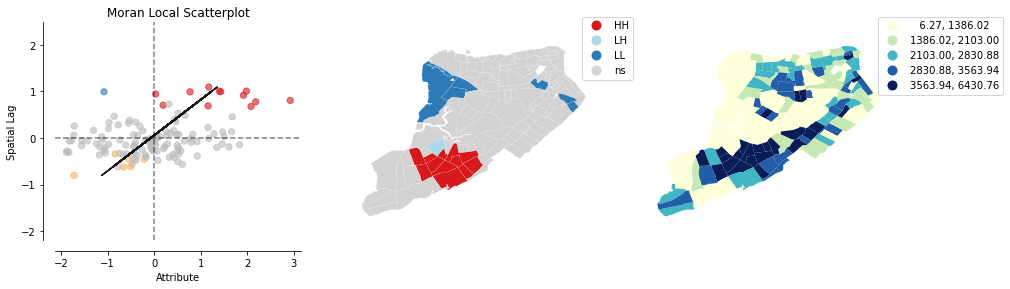

In [115]:
# plot results (at p < 0.05)
plot_local_autocorrelation(local_moran_SI, SI_trees_sqmile,'trees_per_sqmile', p = 0.05 );

plt.savefig("maps/StatenIsland/Staten-Island-per-SquareMile_moran.pdf")

In [116]:
# get clusters and outliers - adding columns to the DF

SI_trees_sqmile['local_moran_Is'] = local_moran_SI.Is
SI_trees_sqmile['local_moran_p_value'] = local_moran_SI.p_sim
SI_trees_sqmile['local_moran_quadrant'] = local_moran_SI.q

In [117]:
# get statisically significant clusters and outliers

alpha = 0.05
hotspots_SI = SI_trees_sqmile.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots_SI = SI_trees_sqmile.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts_SI = SI_trees_sqmile.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds_SI = SI_trees_sqmile.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

/Users/djferrera/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


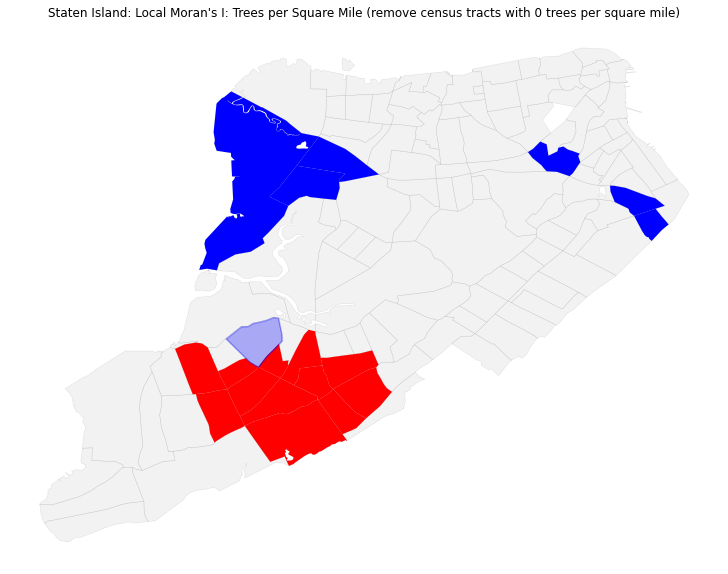

In [118]:
# view clusters and outliers

# create a figure with one subplot
fig, ax = plt.subplots(figsize=(20,10))

# plot census tracts
SI_trees_sqmile.plot(ax = ax, alpha = 0.1, edgecolor = 'black', linewidth = 0.5, color = 'gray')

# plot HH / LL / HL / LH
SI_trees_sqmile.plot(ax = ax, facecolor = 'none', alpha = 0)
hotspots_SI.plot(color = 'red', ax = ax, label = 'Hot Spot')
coldspots_SI.plot(color = 'blue', ax = ax, label = 'Cold Spot')
doughnuts_SI.plot(color = 'blue', alpha = 0.3, edgecolor = 'blue', linewidth = 1.5, ax = ax, label = 'Doughnuts')
diamonds_SI.plot(color = 'red', alpha = 0.3, edgecolor = 'red', linewidth = 1.5, ax = ax, label = 'Diamonds')

ax.axis('off')
ax.set(title = "Staten Island: Local Moran's I: Trees per Square Mile (remove census tracts with 0 trees per square mile)")

plt.savefig("maps/StatenIsland/Staten Island_Trees-per-SquareMile.pdf")

### *investigate the numbers*

In [146]:
# look at smallest values
SI_trees_sqmile['trees_per_sqmile'].nsmallest(n=10)

739       6.269298
1174     27.813898
1073     76.513939
792      91.586490
1814    157.984927
1728    218.848382
1203    225.643266
1662    229.534098
154     443.415306
1682    445.587463
Name: trees_per_sqmile, dtype: float64

In [132]:
# look at largest values
SI_trees_sqmile['trees_per_sqmile'].nlargest(n=10)

153     6430.756099
185     5438.663892
580     5304.959438
585     5172.401344
432     5086.516615
1681    4973.642131
1142    4765.395870
115     4747.776422
1683    4672.984041
1726    4529.223508
Name: trees_per_sqmile, dtype: float64

In [121]:
# lowest 1% of data
print(SI_trees_sqmile['trees_per_sqmile'].quantile(q = 0.01))

38.527906708604746


In [122]:
# lowest 5% of data
print(SI_trees_sqmile['trees_per_sqmile'].quantile(q = 0.05))

226.03234942141168


In [123]:
# lowest 10% of data
print(SI_trees_sqmile['trees_per_sqmile'].quantile(q = 0.10))

885.827103136476


In [124]:
# lowest 20% of data
print(SI_trees_sqmile['trees_per_sqmile'].quantile(q = 0.20))

1386.0218347301366


In [125]:
# highest 1% of data
print(SI_trees_sqmile['trees_per_sqmile'].quantile(q = 0.99))

5409.248911896357


In [126]:
# highest 5% of data
print(SI_trees_sqmile['trees_per_sqmile'].quantile(q = 0.95))

4763.633925281287


In [127]:
# highest 10% of data
print(SI_trees_sqmile['trees_per_sqmile'].quantile(q = 0.90))

4426.830139578349


In [128]:
# highest 20% of data
print(SI_trees_sqmile['trees_per_sqmile'].quantile(q = 0.80))

3563.94054819053


## Spatial Autocorrelation - Local Moran's I - limited
### *removed all census tracts with less than 1,000 and more than 5,000  trees per square mile*

In [133]:
# limit the range
SI_trees_sqmile_limit = SI_trees_sqmile.query("trees_per_sqmile > 1000 & trees_per_sqmile < 50000")

In [134]:
# create queen contiguity weights
w_SI2 = weights.Queen.from_dataframe(SI_trees_sqmile_limit)

In [136]:
# fill in islands with KNN weights
w_knn_SI2 = weights.KNN.from_dataframe(SI_trees_sqmile_limit, k=1)

In [137]:
w_SI2 = weights.attach_islands(w_SI2, w_knn_SI2)

There are no disconnected observations (no islands)!


In [138]:
# row standardize weights
w_SI2.transform = 'R'

In [139]:
# on trees per capita
local_moran_SI2 = esda.moran.Moran_Local(SI_trees_sqmile_limit['trees_per_sqmile'], w_SI2)

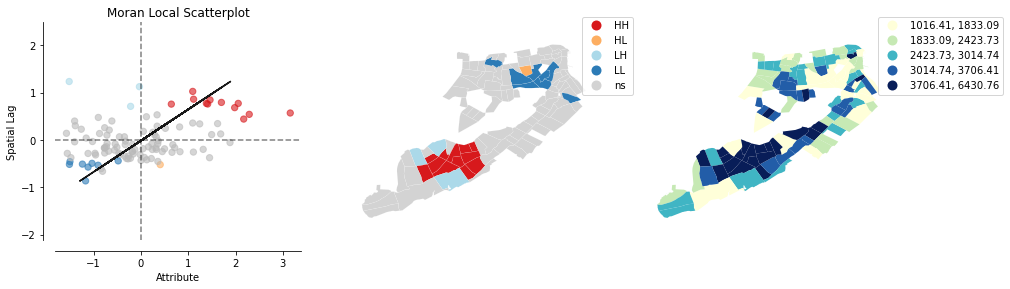

In [140]:
# plot results (at p < 0.05)
plot_local_autocorrelation(local_moran_SI2, SI_trees_sqmile_limit,'trees_per_sqmile', p = 0.05 );

plt.savefig("maps/StatenIsland/Staten-Island_Trees-per-SquareMile_limited_moran.pdf")

In [142]:
# get clusters and outliers
SI_trees_sqmile_limit['local_moran_Is'] = local_moran_SI2.Is
SI_trees_sqmile_limit['local_moran_p_value'] = local_moran_SI2.p_sim
SI_trees_sqmile_limit['local_moran_quadrant'] = local_moran_SI2.q

In [143]:
# get statisically significant clusters and outliers
alpha = 0.05
hotspots_SI2 = SI_trees_sqmile_limit.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots_SI2 = SI_trees_sqmile_limit.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts_SI2 = SI_trees_sqmile_limit.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds_SI2 = SI_trees_sqmile_limit.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

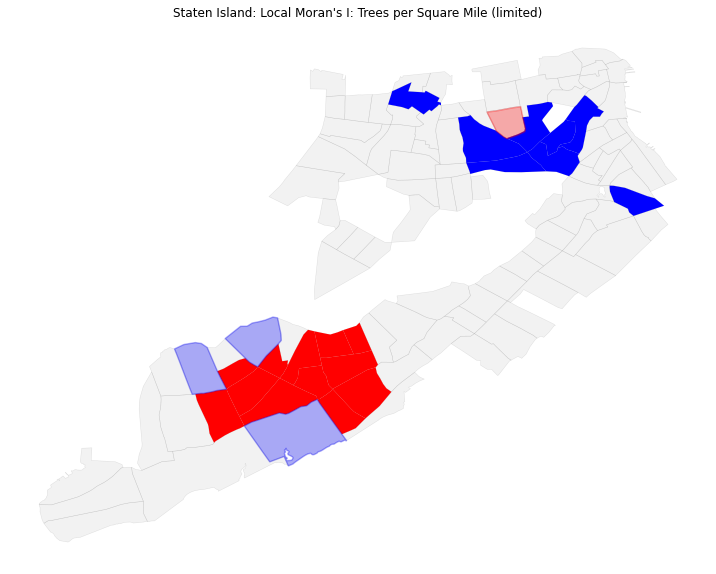

In [144]:
# view clusters and outliers

# create a figure with one subplot
fig, ax = plt.subplots(figsize=(20,10))

# plot census tracts
SI_trees_sqmile_limit.plot(ax = ax, alpha = 0.1, edgecolor = 'black', linewidth = 0.5, color = 'gray')

# plot HH / LL / HL / LH
SI_trees_sqmile_limit.plot(ax = ax, facecolor = 'none', alpha = 0)
hotspots_SI2.plot(color = 'red', ax = ax, label = 'Hot Spot')
coldspots_SI2.plot(color = 'blue', ax = ax, label = 'Cold Spot')
doughnuts_SI2.plot(color = 'blue', alpha = 0.3, edgecolor = 'blue', linewidth = 1.5, ax = ax, label = 'Doughnuts')
diamonds_SI2.plot(color = 'red', alpha = 0.3, edgecolor = 'red', linewidth = 1.5, ax = ax, label = 'Diamonds')

ax.axis('off')
ax.set(title = "Staten Island: Local Moran's I: Trees per Square Mile (limited)")

plt.savefig("maps/StatenIsland/Staten-Island_Trees-per-SquareMile_limited.pdf")